# AOS-573 Final Project
## Bailey Jarrett
### Background

Not much is known about the frequency of sudden stratospheric warmings prior to the sattelite era in the 50s. Domeisen (2019) attempted to establish a relationship between SSWs and the North Atlantic Oscillation Index. What she found is that most SSWs were followed by a "NAO Event", which she defined as either a perisitent negative phase or rapid switch in phase from negative to positive of the NAO Index. However, these NAO events can happen outside of SSWs forcings, and on thier own are not enough to determine if a SSW has occured. I want to see if there is a similar relationship between the North Pacific Index and SSW. The NPI is the standardized area-weighted sea level pressure over the area from 30°N-65°N, 160°E-140°W.

In [1]:
#====================
# Import packages.
#====================
import sys,os
import xarray as xr
import numpy as np
from datetime import datetime, timedelta
import datetime as dt
import matplotlib.pyplot as plt
from NPI.NorthPacificIndex import NorthPacific_Index

I used the NCEP-DOE Reanalysis 2 data for my project. The data spans from January 1979 to November of 2021. I used both daily and monthly mean surface pressure data. The monthly mean data was just one file and was pretty small. The daily mean data was one file per year. Each file was still pretty small but in order to stay under the data constraints I am only analyzing 2009-2021. I also used daily mean u-wind. These were also one file per year but each file was about 160MB because it had values at every pressure level. I created another notebook in this repository, "netcdf_editor.ipynb", where I was able to create new netcfd files from only the 10hPa level at 60N. This allows me to find the daily mean zonal wind at that level which is used as a diagnostic of sudden stratospheric warmings.

[Link to NCEP-DOE Reanalysis 2 Data Site](https://psl.noaa.gov/data/gridded/data.ncep.reanalysis2.html)

In [2]:
#=========================================================
# Declare file variables and load into xarray datasets.
#=========================================================
file_pres_m = '/tornado/home1/class/fall21/bjarrett/AOS573/FinalProject/pres_mon/*.nc'
file_pres_d = '/tornado/home1/class/fall21/bjarrett/AOS573/FinalProject/pres/*.nc'
file_uwnd = '/tornado/home1/class/fall21/bjarrett/AOS573/FinalProject/uwnd/*.nc'

pres_m = xr.open_mfdataset(file_pres_m).drop_vars('time_bnds')
pres_d = xr.open_mfdataset(file_pres_d).drop_vars('time_bnds')
uwind = xr.open_mfdataset(file_uwnd).drop_vars('time_bnds')

I was able to create a function that calculates the NPI index an a weighted running mean as well. This function has been packedged and included in the repository.

In [3]:
#==============================================================
# Use NorthPacificIndex function to calculate NPI and smooth.
#==============================================================
npi_mon,sigma_mon,smooth_mon = NorthPacific_Index.NorthPacific_Index(pres_m, months=[11,12,1,2,3])
npi_day,sigma_day,smooth_day = NorthPacific_Index.NorthPacific_Index(pres_d)

In [4]:
#=====================================================================
# Define time component and colors for negative and positive values.
#=====================================================================
xtime = np.arange(len(npi_mon.time))
c = np.where(npi_mon.pres.values > 0, '#0041ca', np.where(npi_mon.pres.values < 0, '#e9002c','k'))

Text(0.0, 1.0, 'σ = 4.5 hPa')

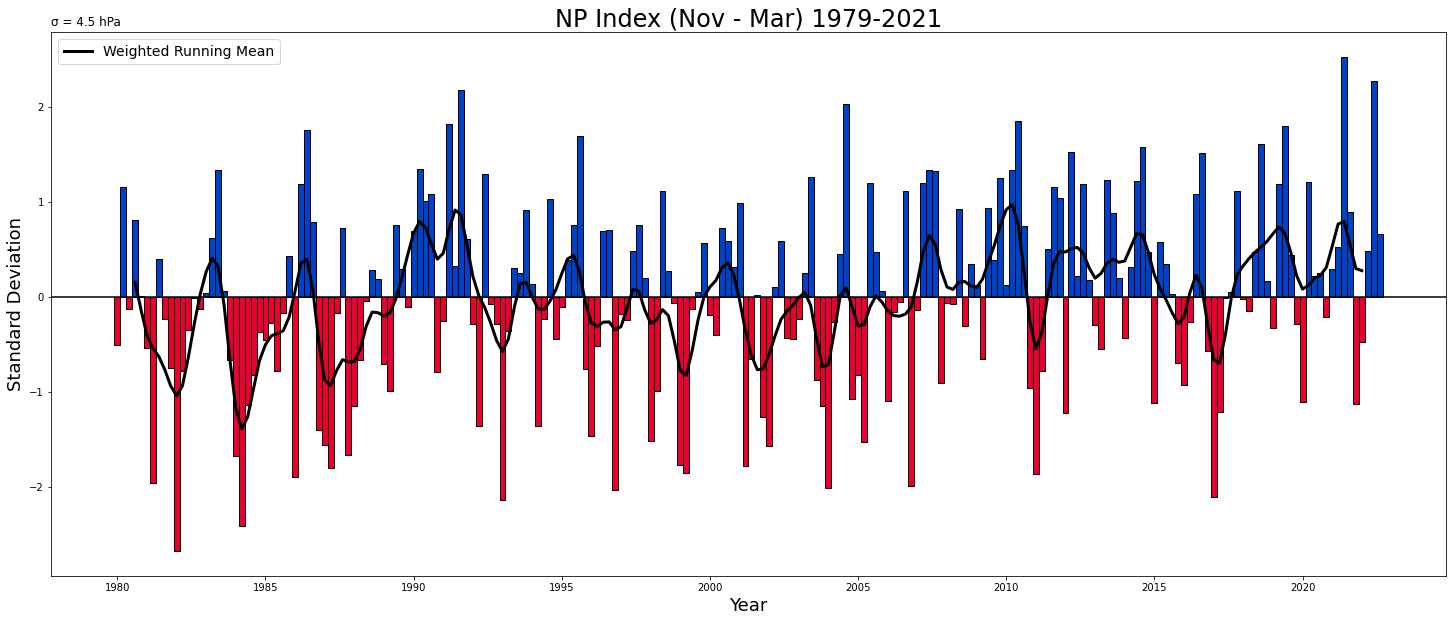

In [7]:
#==================================================================
# Plot the Nov-Mar Monthly NPI Index with weighted running mean.
#==================================================================
fig,ax = plt.subplots(figsize=(25,10))

plt.bar(xtime, npi_mon.pres, color=c, width=1, edgecolor='k')
plt.xticks(xtime[::25],npi_mon.time.dt.year.values[5:215:25])
plt.plot(xtime, smooth_mon.values, color='k', linewidth=3, label='Weighted Running Mean')
plt.axhline(y=0, color='k')
ax.legend(fontsize=14, loc='upper left')
ax.set_xlabel('Year',size=18)
ax.set_ylabel('Standard Deviation',size=18)
ax.set_title('NP Index (Nov - Mar) 1979-2021',size=24)
ax.set_title('σ = 4.5 hPa',loc='left')

In [16]:
#======================================================================
# Find YYYY-MM-DD 20 days prior and 40 days after list of SSW Dates.
#======================================================================
ssw = np.array([['2009-1-24',],['2010-2-9',],['2010-3-24',],['2013-1-7',],['2018-2-12',],['2019-1-2',]],dtype='str')
ssw_range = []

for d in range(len(ssw)):
    date_format = '%Y-%m-%d'
    dtObj = datetime.strptime(ssw[d,0], date_format)
    
    future_date = dtObj + timedelta(days=40)
    past_date = dtObj - timedelta(days=20)
    future_date_str = future_date.strftime(date_format)
    past_date_str = past_date.strftime(date_format)
    ssw_range.append((past_date_str,future_date_str))
print(ssw_range)

[('2009-01-04', '2009-03-05'), ('2010-01-20', '2010-03-21'), ('2010-03-04', '2010-05-03'), ('2012-12-18', '2013-02-16'), ('2018-01-23', '2018-03-24'), ('2018-12-13', '2019-02-11')]


I attmepted to make a function or some sort of for loop that took these lists of dates and manipulated the dataset into these variables for me. I had some mixed success but ultimately ran out of time; I would like to revist this at some point down the road.

In [17]:
#======================================================================
# Use ssw_range dates to split zonal wind data into variables based on 
# central date of ssw.
#======================================================================
z_uwind = uwind.mean('lon') #Finding Zonal Wind

jan09_u = z_uwind.uwnd.sel(time=slice('2009-1-4','2009-3-5')).values
feb10_u = z_uwind.uwnd.sel(time=slice('2010-1-20','2010-3-21')).values
mar10_u = z_uwind.uwnd.sel(time=slice('2010-3-4','2010-5-3')).values
jan13_u = z_uwind.uwnd.sel(time=slice('2012-12-18','2013-2-16')).values
feb18_u = z_uwind.uwnd.sel(time=slice('2018-1-23','2018-3-24')).values
jan19_u = z_uwind.uwnd.sel(time=slice('2018-12-13','2019-2-11')).values

avg = (jan09_u + feb10_u + mar10_u + jan13_u + feb18_u + jan19_u)/6 #Finding average from all events

In [18]:
#======================================================================
# Use ssw_range dates to split NPI data into variables based on 
# central date of ssw.
#======================================================================
jan09_i = npi_day.pres.sel(time=slice('2009-1-4','2009-3-5')).values
feb10_i = npi_day.pres.sel(time=slice('2010-1-20','2010-3-21')).values
mar10_i = npi_day.pres.sel(time=slice('2010-3-4','2010-5-3')).values
jan13_i = npi_day.pres.sel(time=slice('2012-12-18','2013-2-16')).values
feb18_i = npi_day.pres.sel(time=slice('2018-1-23','2018-3-24')).values
jan19_i = npi_day.pres.sel(time=slice('2018-12-13','2019-2-11')).values

avg_pres = (jan09_i + feb10_i + mar10_i + jan13_i + feb18_i + jan19_i)/6 #Finding average from all events

Text(0.5, 1.0, 'NP Index Relative to SSW Event')

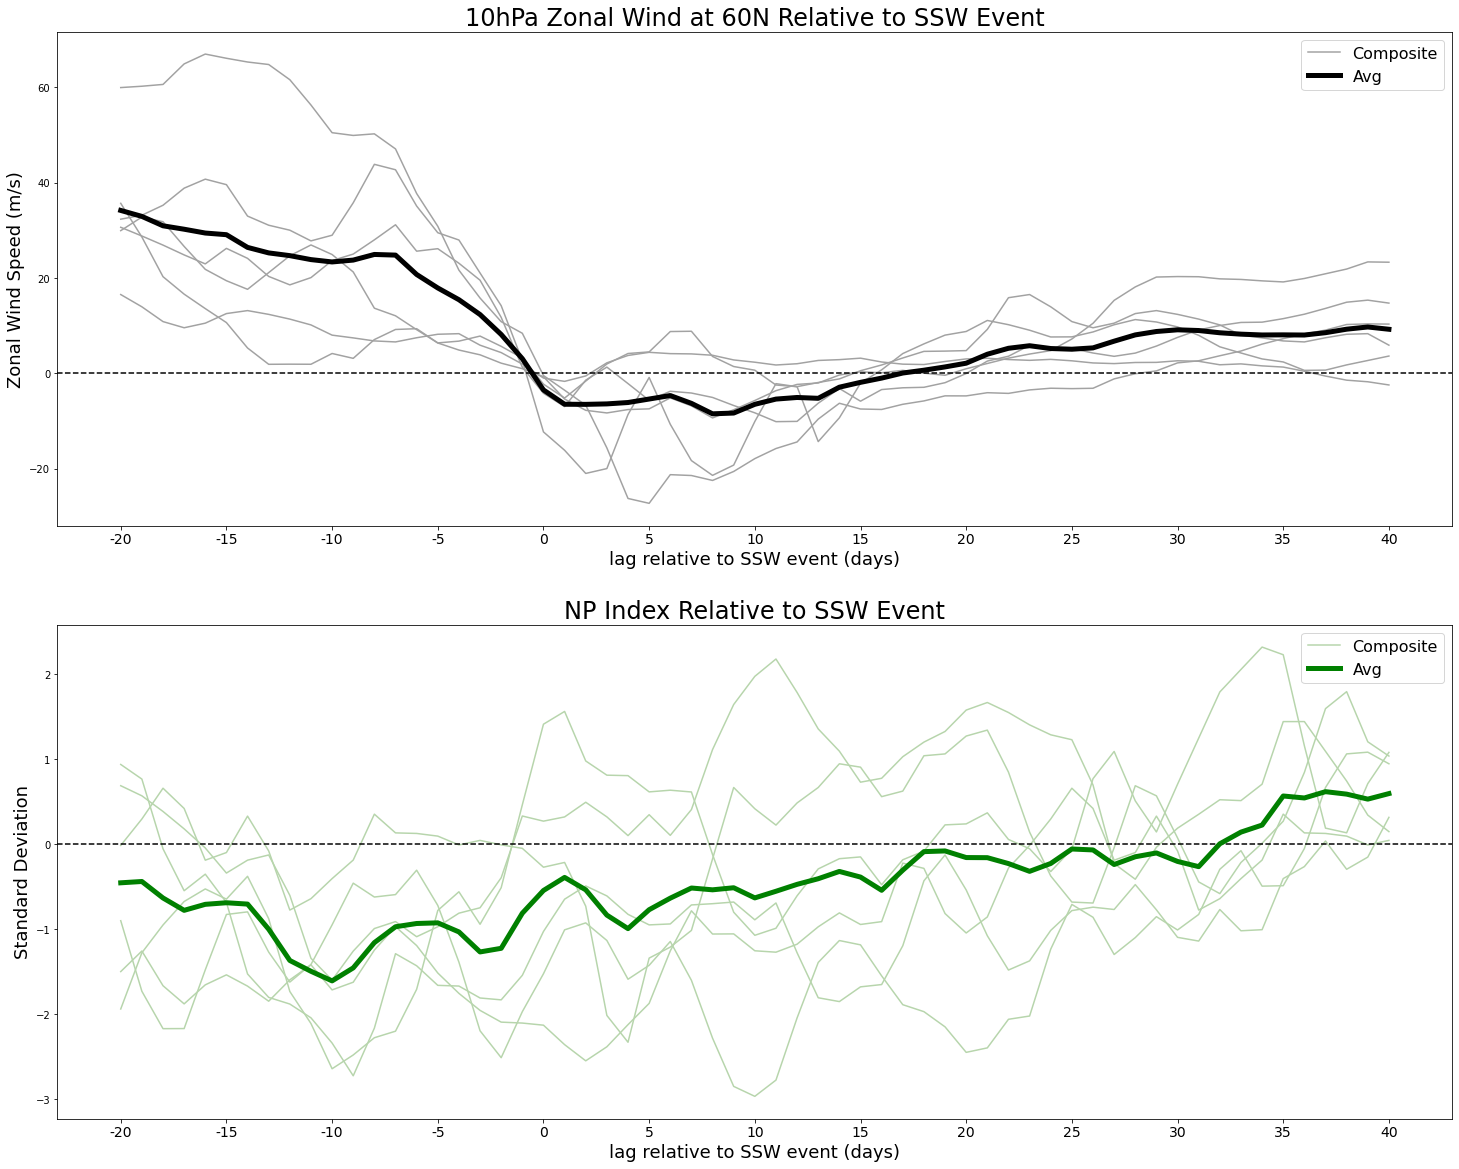

In [25]:
#===============================================================================
# Plot the composite of all zonal wind and NPI for all events and the average.
#===============================================================================
lag = np.arange(0,61) #xvalue for plotting

fig,ax = plt.subplots(ncols=1,nrows=2,figsize=(25,20))
ax=ax.flatten()

# Plot 10hPa 60N Zonal Wind
ax[0].plot(lag,jan09_u,'#a2a2a2',label='Composite')
ax[0].plot(lag,feb10_u,'#a2a2a2')
ax[0].plot(lag,mar10_u,'#a2a2a2')
ax[0].plot(lag,jan13_u,'#a2a2a2')
ax[0].plot(lag,feb18_u,'#a2a2a2')
ax[0].plot(lag,jan19_u,'#a2a2a2')
ax[0].axhline(y=0, color='k',linestyle='--')
ax[0].plot(lag,avg,'#000000',linewidth=5,label='Avg')

ax[0].legend(fontsize=16)
ax[0].set_xticks(lag[::5])
ax[0].set_xticklabels((-20,-15,-10,-5,0,5,10,15,20,25,30,35,40),size=14)
ax[0].set_xlabel('lag relative to SSW event (days)',size=18)
ax[0].set_ylabel('Zonal Wind Speed (m/s)',size=18)
ax[0].set_title('10hPa Zonal Wind at 60N Relative to SSW Event',size=24)

# Plot NPI 
ax[1].plot(lag,jan09_i,'#b7d5ac',label='Composite')
ax[1].plot(lag,feb10_i,'#b7d5ac')
ax[1].plot(lag,mar10_i,'#b7d5ac')
ax[1].plot(lag,jan13_i,'#b7d5ac')
ax[1].plot(lag,feb18_i,'#b7d5ac')
ax[1].plot(lag,jan19_i,'#b7d5ac')
ax[1].axhline(y=0, color='k',linestyle='--')
ax[1].plot(lag,avg_pres,'#008000',linewidth=5,label='Avg')

ax[1].legend(fontsize=16)
ax[1].set_xticks(lag[::5])
ax[1].set_xticklabels((-20,-15,-10,-5,0,5,10,15,20,25,30,35,40),size=14)
ax[1].set_xlabel('lag relative to SSW event (days)',size=18)
ax[1].set_ylabel('Standard Deviation',size=18)
ax[1].set_title('NP Index Relative to SSW Event',size=24)

From these plots, we cann see that there may be a similar relationship to the one found by Domeisen. The overall average of the NPI looks to be a persistent negative trend following an SSW; If we look at the composites we can see that there are some events where there is that rapid shift from negative to positive.
I think this is a great starting point for future work on this project. I think some of the next steps would include expanding this composite analysis to the full time series of the NCEP-DOE Reanalysis 2. I think it would also be beneficial to objectively define these persistent negative and rapid switch phases for the NPI.